# Order returns prediction - binary classification 

Please note - confidential details, data, and few of the output/ visualization charts are not shown for privacy reasons. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
import cx_Oracle as orc

## Data import from Oracle

In [5]:
# Make DSN address
dsn = orc.makedsn('hostname', 'port', service_name='servicename')
# Connect to DSN
conn = orc.connect(user='username', password='password', dsn=dsn)

In [6]:
sql_query = """SELECT 
  ORDER_NUMBER,
  CREATION_DATE,
  COMPLETED_DATE,
  (COMPLETED_DATE - CREATION_DATE) AS DELIVERY_DAYS,
  ORDER_METHOD,
  DELIVERY_WAY, 
  CASE 
    WHEN FAMILY_MEMBER IS NOT NULL 
    THEN 'FAMILY'
    ELSE 'NOT FAMILY'
  END AS FAMILY_CUST,
  CUSTOMER_TYPE,
  DELIVERY_ZIPCODE,
  CREATED_ZIPCODE,
  DELIVERY_CHARGE,
  TOTAL_ORDER_VALUE_NET,
  NUMBER_ARTICLES,
  RETURN_CREAT,
  RETURN_COMPL,
  CASE 
    WHEN PUR_PROOF IS NOT NULL 
    THEN 'RETURNED'
    ELSE 'NOT RETURNED'
  END AS ORDER_STATUS
FROM 
( 
SELECT 
  ORDER_NUMBER,
  TRUNC(CREATION_DATE) AS CREATION_DATE,
  TRUNC(COMPLETED_DATE) AS COMPLETED_DATE,
  ORDER_METHOD,
  DELIVERY_WAY,
  FAMILY_MEMBER,
  CUSTOMER_TYPE,
  DELIVERY_ZIPCODE,
  CREATED_ZIPCODE,
  CBO_FREIGHT_VALUE AS DELIVERY_CHARGE,
  TOTAL_ORDER_VALUE_NET,
  NUMBER_ARTICLES
FROM 
  "DATABASE_NAME"."TABLE_NAME"
WHERE 
  COMPLETED_DATE IS NOT NULL AND
  DELIVERY_WAY NOT IN ('CLICK&COLLECT', 'EXPRESS DELIVERY') AND
  CREATION_DATE >= TO_DATE('01.09.18','DD.MM.YY')) a 
LEFT JOIN 
( 
SELECT 
  MIN(RETURN_CREAT_DT) AS RETURN_CREAT,
  MIN(RETURN_COMPL_DT) AS RETURN_COMPL,
  PUR_PROOF 
FROM  
  "DATABASE_NAME"."TABLE_NAME"
WHERE 
  SELLING_STO_ID = 52 AND
  RETURN_CREAT_DT >= TO_DATE('01.09.18','DD.MM.YY') AND
  PUR_PROOF IS NOT NULL 
GROUP BY
  PUR_PROOF) b
ON 
  a.ORDER_NUMBER = b.PUR_PROOF
WHERE 
  CREATION_DATE IS NOT NULL AND
  CREATION_DATE >= TO_DATE('01.09.18','DD.MM.YY')"""

In [7]:
original_df = pd.read_sql(sql_query, conn)

In [8]:
df_a1 = original_df.copy()

## Data exploration

In [9]:
df_a1.head()

,ORDER_NUMBER,CREATION_DATE,COMPLETED_DATE,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,CUSTOMER_TYPE,DELIVERY_ZIPCODE,CREATED_ZIPCODE,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,RETURN_CREAT,RETURN_COMPL,ORDER_STATUS
0,1005665161,2018-12-14,2018-12-20,6,INTERNET,PARCEL,FAMILY,PRIVATE,53757,53757,3.9,32.68,1.0,NaT,NaT,NOT RETURNED
1,1005428825,2018-12-13,2018-12-19,6,PHONE,PARCEL,NOT FAMILY,PRIVATE,81669,81669,0.0,0.00,1.0,NaT,NaT,NOT RETURNED
2,1007196172,2018-12-14,2018-12-27,13,INTERNET,PARCEL,FAMILY,PRIVATE,76297,76297,3.9,24.28,1.0,NaT,NaT,NOT RETURNED
3,1002440897,2018-11-18,2018-11-26,8,INTERNET,PARCEL,NOT FAMILY,PRIVATE,67125,67125,3.9,45.29,1.0,NaT,NaT,NOT RETURNED
4,1000557302,2018-11-18,2018-11-27,9,INTERNET,PARCEL,NOT FAMILY,PRIVATE,18356,18356,3.9,28.94,7.0,NaT,NaT,NOT RETURNED


In [10]:
df_a1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984273 entries, 0 to 2984272
Data columns (total 16 columns):
ORDER_NUMBER             int64
CREATION_DATE            datetime64[ns]
COMPLETED_DATE           datetime64[ns]
DELIVERY_DAYS            int64
ORDER_METHOD             object
DELIVERY_WAY             object
FAMILY_CUST              object
CUSTOMER_TYPE            object
DELIVERY_ZIPCODE         object
CREATED_ZIPCODE          object
DELIVERY_CHARGE          float64
TOTAL_ORDER_VALUE_NET    float64
NUMBER_ARTICLES          float64
RETURN_CREAT             datetime64[ns]
RETURN_COMPL             datetime64[ns]
ORDER_STATUS             object
dtypes: datetime64[ns](4), float64(3), int64(2), object(7)
memory usage: 364.3+ MB


In [11]:
pd.set_option('display.float_format','{:.2f}'.format)
df_a1.describe(include='all')

,ORDER_NUMBER,CREATION_DATE,COMPLETED_DATE,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,CUSTOMER_TYPE,DELIVERY_ZIPCODE,CREATED_ZIPCODE,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,RETURN_CREAT,RETURN_COMPL,ORDER_STATUS
count,2984273.00,2984273,2984273,2984273.00,2984273,2984273,2984273,2984241,2984273,2979094,2984273.00,2984241.00,2981577.00,130294,128899,2984273
unique,nan,402,347,nan,5,3,2,2,8441,9849,nan,nan,nan,129430,125798,2
top,nan,2018-11-25 00:00:00,2018-10-18 00:00:00,nan,INTERNET,PARCEL,NOT FAMILY,PRIVATE,78467,78467,nan,nan,nan,2018-11-19 12:15:57,2019-05-02 16:06:49,NOT RETURNED
freq,nan,16226,33654,nan,2890139,2136233,2217839,2831982,3881,3873,nan,nan,nan,3,6,2853979
first,nan,2018-09-01 00:00:00,2018-09-06 00:00:00,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,2018-10-10 07:18:36,2018-10-10 10:01:13,NaN
last,nan,2019-10-07 00:00:00,2019-10-09 00:00:00,nan,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,2019-10-08 20:27:04,2019-10-08 20:26:17,NaN
mean,1001398931.13,NaN,NaN,10.32,NaN,NaN,NaN,NaN,NaN,NaN,17.77,160.41,8.74,NaN,NaN,NaN
std,82999675.15,NaN,NaN,8.23,NaN,NaN,NaN,NaN,NaN,NaN,31.05,331.44,28.55,NaN,NaN,NaN
min,521201305.00,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,1.00,NaN,NaN,NaN
25%,1004238339.00,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN,NaN,3.90,25.46,2.00,NaN,NaN,NaN


In [12]:
df_a1['CREATION_DAY'] = pd.DatetimeIndex(df_a1['CREATION_DATE']).weekday_name
df_a1['CREATION_MONTH'] = pd.DatetimeIndex(df_a1['CREATION_DATE']).month
df_a1['CREATION_YEAR'] = pd.DatetimeIndex(df_a1['CREATION_DATE']).year

In [13]:
df_a1['COMPLETED_DAY'] = pd.DatetimeIndex(df_a1['COMPLETED_DATE']).weekday_name
df_a1['COMPLETED_MONTH'] = pd.DatetimeIndex(df_a1['COMPLETED_DATE']).month
df_a1['COMPLETED_YEAR'] = pd.DatetimeIndex(df_a1['COMPLETED_DATE']).year

In [14]:
df_a1['DELIVERY_ZIPCODE'] = df_a1['DELIVERY_ZIPCODE'].str[1]
df_a1['CREATED_ZIPCODE'] = df_a1['CREATED_ZIPCODE'].str[1]

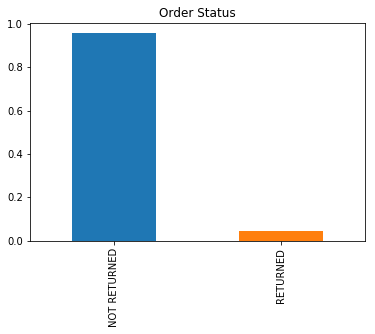

In [16]:
df_a1['ORDER_STATUS'].value_counts(normalize=True).plot.bar(title='Order Status')

In [17]:
df_a1['ORDER_STATUS'].value_counts(normalize=True)

NOT RETURNED   0.96
RETURNED       0.04
Name: ORDER_STATUS, dtype: float64

In [18]:
df_a1['ORDER_STATUS'].value_counts()

NOT RETURNED    2853979
RETURNED         130294
Name: ORDER_STATUS, dtype: int64

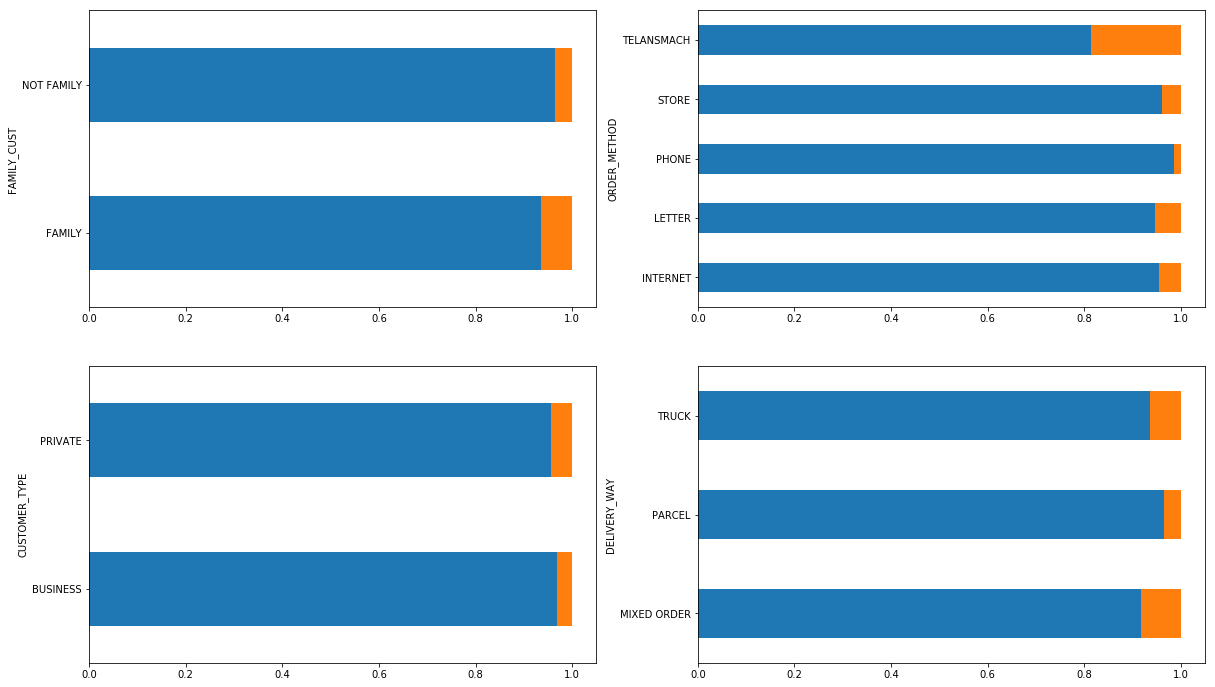

In [13]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(221)
pd.crosstab(df_a1['FAMILY_CUST'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax1, legend=False)
ax2 = fig.add_subplot(222)
pd.crosstab(df_a1['ORDER_METHOD'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax2, legend=False)
ax3 = fig.add_subplot(223)
pd.crosstab(df_a1['CUSTOMER_TYPE'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax3, legend=False)
ax4 = fig.add_subplot(224)
pd.crosstab(df_a1['DELIVERY_WAY'], df_a1['ORDER_STATUS'], normalize='index').plot.barh(stacked=True, ax=ax4, legend=False)
plt.show()

In [25]:
df_a1['ORDER_STATUS'].replace('NOT RETURNED', 0, inplace=True)
df_a1['ORDER_STATUS'].replace('RETURNED', 1, inplace=True)

In [26]:
df_a1.corr(method='spearman')

,ORDER_NUMBER,DELIVERY_DAYS,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,ORDER_STATUS,CREATION_MONTH,CREATION_YEAR,COMPLETED_MONTH,COMPLETED_YEAR
ORDER_NUMBER,1.00,-0.40,0.20,0.03,0.01,-0.00,-0.29,0.81,-0.20,0.78
DELIVERY_DAYS,-0.40,1.00,0.10,0.21,0.12,0.03,0.28,-0.43,0.18,-0.36
DELIVERY_CHARGE,0.20,0.10,1.00,0.66,0.28,0.07,0.01,0.12,0.03,0.12
TOTAL_ORDER_VALUE_NET,0.03,0.21,0.66,1.00,0.49,0.14,-0.00,0.02,0.01,0.02
NUMBER_ARTICLES,0.01,0.12,0.28,0.49,1.00,0.12,-0.00,0.01,0.00,0.01
ORDER_STATUS,-0.00,0.03,0.07,0.14,0.12,1.00,-0.01,0.00,-0.01,0.00
CREATION_MONTH,-0.29,0.28,0.01,-0.00,-0.00,-0.01,1.00,-0.79,0.81,-0.70
CREATION_YEAR,0.81,-0.43,0.12,0.02,0.01,0.00,-0.79,1.00,-0.62,0.92
COMPLETED_MONTH,-0.20,0.18,0.03,0.01,0.00,-0.01,0.81,-0.62,1.00,-0.76
COMPLETED_YEAR,0.78,-0.36,0.12,0.02,0.01,0.00,-0.70,0.92,-0.76,1.00


## Handling missing values

In [27]:
df_a1.isnull().sum()

ORDER_NUMBER                   0
CREATION_DATE                  0
COMPLETED_DATE                 0
DELIVERY_DAYS                  0
ORDER_METHOD                   0
DELIVERY_WAY                   0
FAMILY_CUST                    0
CUSTOMER_TYPE                 32
DELIVERY_ZIPCODE               0
CREATED_ZIPCODE             5179
DELIVERY_CHARGE                0
TOTAL_ORDER_VALUE_NET         32
NUMBER_ARTICLES             2696
RETURN_CREAT             2853979
RETURN_COMPL             2855374
ORDER_STATUS                   0
CREATION_DAY                   0
CREATION_MONTH                 0
CREATION_YEAR                  0
COMPLETED_DAY                  0
COMPLETED_MONTH                0
COMPLETED_YEAR                 0
dtype: int64

In [28]:
len(df_a1[(df_a1['CREATED_ZIPCODE']!=df_a1['DELIVERY_ZIPCODE'])])

5337

In [29]:
df_a2 = df_a1.drop(['RETURN_CREAT', 'RETURN_COMPL', 'CREATED_ZIPCODE'], axis=1)

In [30]:
df_a2['CUSTOMER_TYPE'].value_counts()

PRIVATE     2831982
BUSINESS     152259
Name: CUSTOMER_TYPE, dtype: int64

In [31]:
df_a2['CUSTOMER_TYPE'].fillna(df_a2['CUSTOMER_TYPE'].mode()[0], inplace=True)

In [32]:
df_a2['TOTAL_ORDER_VALUE_NET'].fillna(df_a2['TOTAL_ORDER_VALUE_NET'].median(), inplace=True)
df_a2['NUMBER_ARTICLES'].fillna(df_a2['NUMBER_ARTICLES'].median(), inplace=True)

In [33]:
df_a2.isnull().sum()

ORDER_NUMBER             0
CREATION_DATE            0
COMPLETED_DATE           0
DELIVERY_DAYS            0
ORDER_METHOD             0
DELIVERY_WAY             0
FAMILY_CUST              0
CUSTOMER_TYPE            0
DELIVERY_ZIPCODE         0
DELIVERY_CHARGE          0
TOTAL_ORDER_VALUE_NET    0
NUMBER_ARTICLES          0
ORDER_STATUS             0
CREATION_DAY             0
CREATION_MONTH           0
CREATION_YEAR            0
COMPLETED_DAY            0
COMPLETED_MONTH          0
COMPLETED_YEAR           0
dtype: int64

## Outliers treatment

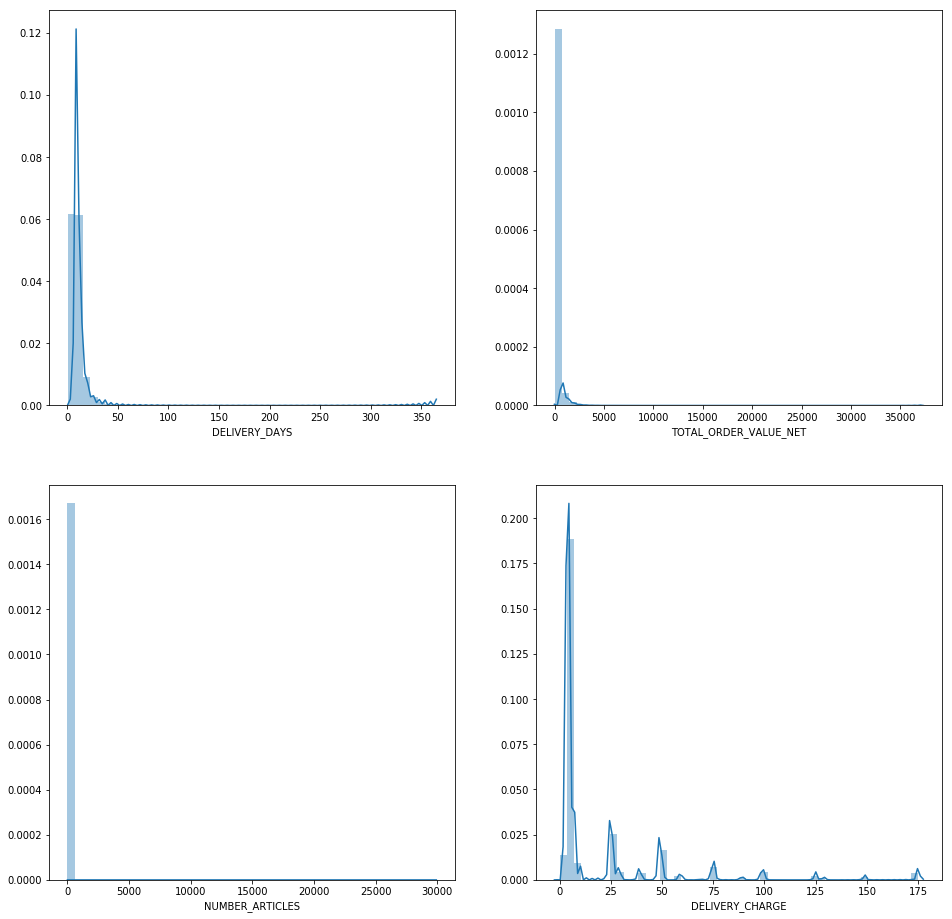

In [36]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
sns.distplot(df_a2['DELIVERY_DAYS'], hist=True, ax=ax1)
ax2 = fig.add_subplot(222)
sns.distplot(df_a2['TOTAL_ORDER_VALUE_NET'], hist=True, ax=ax2)
ax3 = fig.add_subplot(223)
sns.distplot(df_a2['NUMBER_ARTICLES'], hist=True, ax=ax3)
ax4 = fig.add_subplot(224)
sns.distplot(df_a2['DELIVERY_CHARGE'], hist=True, ax=ax4)
plt.show()

In [37]:
len(df_a2[df_a2['NUMBER_ARTICLES']>100])

13410

In [38]:
len(df_a2[df_a2['DELIVERY_DAYS']>50])

14660

In [39]:
len(df_a2[df_a2['TOTAL_ORDER_VALUE_NET']>2100])

14288

In [40]:
len(df_a2[(df_a2['NUMBER_ARTICLES']>100) | (df_a2['DELIVERY_DAYS']>50) | (df_a2['TOTAL_ORDER_VALUE_NET']>2100)])

36318

In [41]:
df_outlier = df_a2[(df_a2['NUMBER_ARTICLES']>100) | (df_a2['DELIVERY_DAYS']>50) | (df_a2['TOTAL_ORDER_VALUE_NET']>2100)]

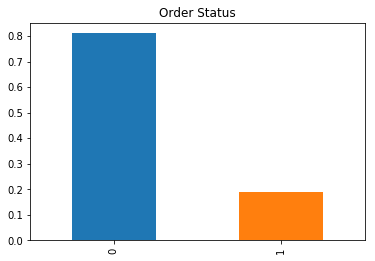

In [42]:
df_outlier['ORDER_STATUS'].value_counts(normalize=True).plot.bar(title='Order Status')

In [43]:
df_b1 = df_a2[(df_a2['NUMBER_ARTICLES']<=100) & (df_a2['DELIVERY_DAYS']<=50) & (df_a2['TOTAL_ORDER_VALUE_NET']<=2100)]

In [44]:
df_a3 = df_a2.copy()

In [45]:
df_a3['NUMBER_ARTICLES'] = df_a3['NUMBER_ARTICLES'].clip(0, 100)

In [46]:
df_a3['DELIVERY_DAYS'] = df_a3['DELIVERY_DAYS'].clip(0, 50)

In [47]:
df_a3['TOTAL_ORDER_VALUE_NET'] = df_a3['TOTAL_ORDER_VALUE_NET'].clip(0, 2100)

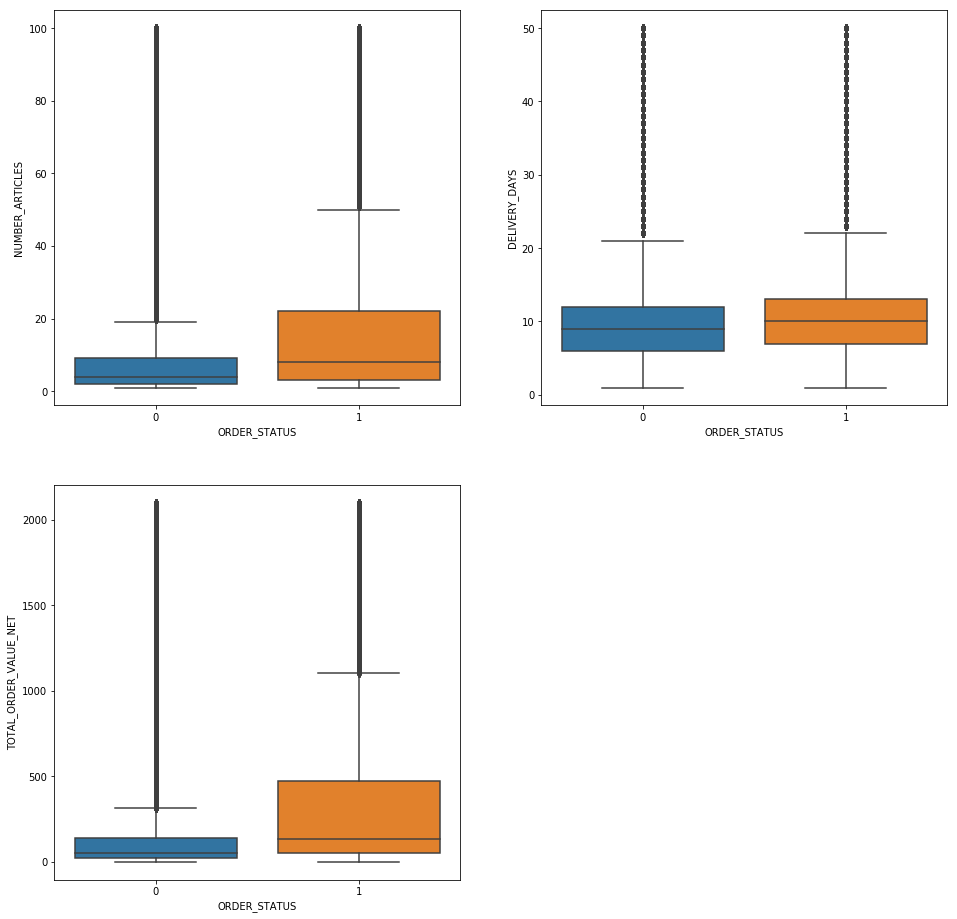

In [48]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)
sns.boxplot(x=df_a3['ORDER_STATUS'], y=df_a3['NUMBER_ARTICLES'], ax=ax1)
ax2 = fig.add_subplot(222)
sns.boxplot(x=df_a3['ORDER_STATUS'], y=df_a3['DELIVERY_DAYS'], ax=ax2)
ax3 = fig.add_subplot(223)
sns.boxplot(x=df_a3['ORDER_STATUS'], y=df_a3['TOTAL_ORDER_VALUE_NET'], ax=ax3)
plt.show()

In [49]:
df_a3.head()

,ORDER_NUMBER,CREATION_DATE,COMPLETED_DATE,DELIVERY_DAYS,ORDER_METHOD,DELIVERY_WAY,FAMILY_CUST,CUSTOMER_TYPE,DELIVERY_ZIPCODE,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,ORDER_STATUS,CREATION_DAY,CREATION_MONTH,CREATION_YEAR,COMPLETED_DAY,COMPLETED_MONTH,COMPLETED_YEAR
0,1003228436,2018-12-11,2019-01-03,23,INTERNET,TRUCK,NOT FAMILY,PRIVATE,3,49.00,352.10,4.00,0,Tuesday,12,2018,Thursday,1,2019
1,1006775526,2018-12-11,2018-12-27,16,INTERNET,PARCEL,NOT FAMILY,PRIVATE,9,3.90,45.29,1.00,0,Tuesday,12,2018,Thursday,12,2018
2,1004023040,2018-12-11,2018-12-27,16,INTERNET,PARCEL,NOT FAMILY,PRIVATE,8,3.90,36.88,2.00,0,Tuesday,12,2018,Thursday,12,2018
3,1006574902,2018-12-10,2018-12-27,17,INTERNET,PARCEL,NOT FAMILY,PRIVATE,5,3.90,17.56,1.00,0,Monday,12,2018,Thursday,12,2018
4,1004384508,2018-12-07,2018-12-28,21,INTERNET,TRUCK,NOT FAMILY,PRIVATE,1,49.00,316.81,4.00,0,Friday,12,2018,Friday,12,2018


## Sampling of dataset

In [51]:
#downsampling for outliers limited dataframe
shuffled_df1 = df_a3.sample(frac=1, random_state=1000)
df_majority1 = shuffled_df1.loc[shuffled_df1['ORDER_STATUS']==0].sample(n=900000, random_state=1000)
df_minority1 = shuffled_df1.loc[shuffled_df1['ORDER_STATUS']==1]
df_downsampled1 = pd.concat([df_majority1, df_minority1])
df_downsampled1 = df_downsampled1.sample(frac=1, random_state=1000)
df_downsampled1['ORDER_STATUS'].value_counts()

0    900000
1    130294
Name: ORDER_STATUS, dtype: int64

In [52]:
#downsampling for outliers removed dataframe
shuffled_df2 = df_b1.sample(frac=1, random_state=1000)
df_majority2 = shuffled_df2.loc[shuffled_df2['ORDER_STATUS']==0].sample(n=900000, random_state=1000)
df_minority2 = shuffled_df2.loc[shuffled_df2['ORDER_STATUS']==1]
df_downsampled2 = pd.concat([df_majority2, df_minority2])
df_downsampled2 = df_downsampled2.sample(frac=1, random_state=1000)
df_downsampled2['ORDER_STATUS'].value_counts()

0    900000
1    123426
Name: ORDER_STATUS, dtype: int64

In [53]:
df_a4 = df_downsampled1.copy()
df_b2 = df_downsampled2.copy()

## Building the classifier model 

In [219]:
X = df_a3.drop(['ORDER_STATUS', 'CREATION_DATE', 'COMPLETED_DATE', 'ORDER_NUMBER', 'DELIVERY_ZIPCODE', 'CREATION_DAY', 'COMPLETED_DAY'], axis=1)
y = df_a3.ORDER_STATUS

In [220]:
X = pd.get_dummies(X)

In [221]:
X.head()

,DELIVERY_DAYS,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,CREATION_MONTH,CREATION_YEAR,COMPLETED_MONTH,COMPLETED_YEAR,ORDER_METHOD_INTERNET,ORDER_METHOD_LETTER,ORDER_METHOD_PHONE,ORDER_METHOD_STORE,ORDER_METHOD_TELANSMACH,DELIVERY_WAY_MIXED ORDER,DELIVERY_WAY_PARCEL,DELIVERY_WAY_TRUCK,FAMILY_CUST_FAMILY,FAMILY_CUST_NOT FAMILY,CUSTOMER_TYPE_BUSINESS,CUSTOMER_TYPE_PRIVATE
0,23,49.00,352.10,4.00,12,2018,1,2019,1,0,0,0,0,0,0,1,0,1,0,1
1,16,3.90,45.29,1.00,12,2018,12,2018,1,0,0,0,0,0,1,0,0,1,0,1
2,16,3.90,36.88,2.00,12,2018,12,2018,1,0,0,0,0,0,1,0,0,1,0,1
3,17,3.90,17.56,1.00,12,2018,12,2018,1,0,0,0,0,0,1,0,0,1,0,1
4,21,49.00,316.81,4.00,12,2018,12,2018,1,0,0,0,0,0,0,1,0,1,0,1


In [222]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2984273 entries, 0 to 2984272
Data columns (total 20 columns):
DELIVERY_DAYS               int64
DELIVERY_CHARGE             float64
TOTAL_ORDER_VALUE_NET       float64
NUMBER_ARTICLES             float64
CREATION_MONTH              int64
CREATION_YEAR               int64
COMPLETED_MONTH             int64
COMPLETED_YEAR              int64
ORDER_METHOD_INTERNET       uint8
ORDER_METHOD_LETTER         uint8
ORDER_METHOD_PHONE          uint8
ORDER_METHOD_STORE          uint8
ORDER_METHOD_TELANSMACH     uint8
DELIVERY_WAY_MIXED ORDER    uint8
DELIVERY_WAY_PARCEL         uint8
DELIVERY_WAY_TRUCK          uint8
FAMILY_CUST_FAMILY          uint8
FAMILY_CUST_NOT FAMILY      uint8
CUSTOMER_TYPE_BUSINESS      uint8
CUSTOMER_TYPE_PRIVATE       uint8
dtypes: float64(3), int64(5), uint8(12)
memory usage: 216.3 MB


In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

In [224]:
model_features = list(X_train.columns)

### Scaler transformation 

In [225]:
sc = StandardScaler()

In [226]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [227]:
# Logistics classifier
C = [0.1, 0.5]
for c in C:
    print('C value is: ' + str(c))
    model = LogisticRegression(C=c, penalty='l1')
    model.fit(X_train, y_train)
    print('Features importance: ')
    for feature in zip(model_features, model.coef_[0]):
        print(feature)
    pred_test = model.predict(X_test)
    print('Accuracy score: ' + str(accuracy_score(y_test, pred_test)))
    print(confusion_matrix(y_test, pred_test))
    print(classification_report(y_test, pred_test))

C value is: 0.1
Features importance: 
('DELIVERY_DAYS', 0.020287876498891057)
('DELIVERY_CHARGE', 0.014583188254919607)
('TOTAL_ORDER_VALUE_NET', 0.2623340213538226)
('NUMBER_ARTICLES', 0.20281284549442205)
('CREATION_MONTH', -0.12482646540699167)
('CREATION_YEAR', -0.15800549139514644)
('COMPLETED_MONTH', 0.008351521469213004)
('COMPLETED_YEAR', 0.06847349405119947)
('ORDER_METHOD_INTERNET', 0.06382346525584937)
('ORDER_METHOD_LETTER', 0.007029519531948029)
('ORDER_METHOD_PHONE', -0.0935970461524137)
('ORDER_METHOD_STORE', 0.0007541629145517053)
('ORDER_METHOD_TELANSMACH', 0.003429030741907612)
('DELIVERY_WAY_MIXED ORDER', 0.0)
('DELIVERY_WAY_PARCEL', 0.007753423777207876)
('DELIVERY_WAY_TRUCK', -0.02851287404836172)
('FAMILY_CUST_FAMILY', 0.12359956181165854)
('FAMILY_CUST_NOT FAMILY', -0.06397787592592166)
('CUSTOMER_TYPE_BUSINESS', -0.030980579113112222)
('CUSTOMER_TYPE_PRIVATE', 0.09303777980860793)
Accuracy score: 0.956480751316345
[[855514    892]
 [ 38070    806]]
             

In [145]:
# Examples for false negatives
df_fn = X_test[(y_test == 1) & (pred_test.T == 0)]
df_fn.head()

,DELIVERY_DAYS,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,CREATION_MONTH,CREATION_YEAR,COMPLETED_MONTH,COMPLETED_YEAR,ORDER_METHOD_INTERNET,ORDER_METHOD_LETTER,ORDER_METHOD_PHONE,ORDER_METHOD_STORE,ORDER_METHOD_TELANSMACH,DELIVERY_WAY_MIXED ORDER,DELIVERY_WAY_PARCEL,DELIVERY_WAY_TRUCK,FAMILY_CUST_FAMILY,FAMILY_CUST_NOT FAMILY,CUSTOMER_TYPE_BUSINESS,CUSTOMER_TYPE_PRIVATE
1256189,10,7.00,172.98,6.00,5,2019,6,2019,1,0,0,0,0,0,1,0,0,1,0,1
396086,10,99.00,652.10,47.00,2,2019,3,2019,1,0,0,0,0,0,0,1,1,0,0,1
1558019,6,3.90,104.10,2.00,3,2019,3,2019,1,0,0,0,0,0,1,0,1,0,0,1
944414,5,4.00,65.39,8.00,7,2019,7,2019,1,0,0,0,0,0,1,0,0,1,0,1
1137198,8,3.90,168.78,6.00,5,2019,5,2019,1,0,0,0,0,0,1,0,0,1,0,1


In [146]:
# Examples for false positives
df_fp = X_test[(y_test == 0) & (pred_test.T == 1)]
df_fp.head()

,DELIVERY_DAYS,DELIVERY_CHARGE,TOTAL_ORDER_VALUE_NET,NUMBER_ARTICLES,CREATION_MONTH,CREATION_YEAR,COMPLETED_MONTH,COMPLETED_YEAR,ORDER_METHOD_INTERNET,ORDER_METHOD_LETTER,ORDER_METHOD_PHONE,ORDER_METHOD_STORE,ORDER_METHOD_TELANSMACH,DELIVERY_WAY_MIXED ORDER,DELIVERY_WAY_PARCEL,DELIVERY_WAY_TRUCK,FAMILY_CUST_FAMILY,FAMILY_CUST_NOT FAMILY,CUSTOMER_TYPE_BUSINESS,CUSTOMER_TYPE_PRIVATE
2057054,31,0.00,1946.98,85.00,6,2019,7,2019,1,0,0,0,0,1,0,0,0,1,0,1
2901234,16,175.00,1508.24,31.00,9,2018,10,2018,1,0,0,0,0,0,0,1,1,0,0,1
2245002,13,175.00,1540.34,57.00,11,2018,11,2018,1,0,0,0,0,0,0,1,0,1,0,1
2301615,10,175.00,1862.16,54.00,4,2019,4,2019,1,0,0,0,0,0,0,1,0,1,0,1
717556,26,75.00,516.32,94.00,3,2019,3,2019,1,0,0,0,0,0,0,1,1,0,0,1


In [228]:
# Naive Bayes classifier - GaussianNB
model2 = GaussianNB() 

In [229]:
model2.fit(X_train, y_train)

GaussianNB(priors=None)

In [230]:
pred_test2 = model2.predict(X_test)

In [231]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test2)))

Accuracy score: 0.8858058131404407


In [232]:
confusion_matrix(y_test, pred_test2)

array([[782805,  73601],
       [ 28635,  10241]], dtype=int64)

In [233]:
print(classification_report(y_test, pred_test2))

             precision    recall  f1-score   support

          0       0.96      0.91      0.94    856406
          1       0.12      0.26      0.17     38876

avg / total       0.93      0.89      0.91    895282



In [191]:
# Naive Bayes classifier - MultinomialNB
model4 = MultinomialNB() 

In [192]:
model4.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [193]:
pred_test4 = model4.predict(X_test)

In [194]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test4)))

Accuracy score: 0.7843630798896111


In [195]:
confusion_matrix(y_test, pred_test4)

array([[228069,  42004],
       [ 24647,  14369]], dtype=int64)

In [196]:
print(classification_report(y_test, pred_test4))

             precision    recall  f1-score   support

          0       0.90      0.84      0.87    270073
          1       0.25      0.37      0.30     39016

avg / total       0.82      0.78      0.80    309089



In [234]:
# Naive Bayes classifier - BernoulliNB
model5 = BernoulliNB() 

In [235]:
model5.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [236]:
pred_test5 = model5.predict(X_test)

In [237]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test5)))

Accuracy score: 0.9300790142100478


In [238]:
confusion_matrix(y_test, pred_test5)

array([[826965,  29441],
       [ 33158,   5718]], dtype=int64)

In [202]:
print(classification_report(y_test, pred_test5))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93    270073
          1       0.50      0.00      0.00     39016

avg / total       0.83      0.87      0.81    309089



In [239]:
# Ada boost classifier
model3 = AdaBoostClassifier() 

In [240]:
model3.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [241]:
pred_test3 = model3.predict(X_test)

In [242]:
print('Accuracy score: ' + str(accuracy_score(y_test, pred_test3)))

Accuracy score: 0.9565768104351479


In [243]:
confusion_matrix(y_test, pred_test3)

array([[856406,      0],
       [ 38876,      0]], dtype=int64)

In [244]:
print(classification_report(y_test, pred_test3))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98    856406
          1       0.00      0.00      0.00     38876

avg / total       0.92      0.96      0.94    895282



In [245]:
#Random forest classifier
model6 = RandomForestClassifier(n_estimators=100, max_depth=3)

In [246]:
model6.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [211]:
pred_test6 = model6.predict(X_test)

In [213]:
confusion_matrix(y_test, pred_test6)

array([[270073,      0],
       [ 39016,      0]], dtype=int64)

In [214]:
print(classification_report(y_test, pred_test6))

             precision    recall  f1-score   support

          0       0.87      1.00      0.93    270073
          1       0.00      0.00      0.00     39016

avg / total       0.76      0.87      0.81    309089



In [177]:
#Features importance
for feature in zip(model_features, model6.feature_importances_):
    print(feature)

('DELIVERY_DAYS', 0.010334447368286905)
('DELIVERY_CHARGE', 0.18555524325387707)
('TOTAL_ORDER_VALUE_NET', 0.3646954215354373)
('NUMBER_ARTICLES', 0.20566587514293044)
('CREATION_MONTH', 0.0011018365943920464)
('CREATION_YEAR', 5.0797548994297845e-06)
('COMPLETED_MONTH', 0.0031124795423279118)
('COMPLETED_YEAR', 4.287047028885607e-05)
('ORDER_METHOD_INTERNET', 0.006180659271829734)
('ORDER_METHOD_LETTER', 4.97415163458565e-06)
('ORDER_METHOD_PHONE', 0.010728552330557696)
('ORDER_METHOD_STORE', 0.0)
('ORDER_METHOD_TELANSMACH', 8.17868129110129e-06)
('DELIVERY_WAY_MIXED ORDER', 0.005091166628245145)
('DELIVERY_WAY_PARCEL', 0.048229470133075075)
('DELIVERY_WAY_TRUCK', 0.03514713006350536)
('FAMILY_CUST_FAMILY', 0.06351765756816119)
('FAMILY_CUST_NOT FAMILY', 0.056198130386405996)
('CUSTOMER_TYPE_BUSINESS', 0.002118989661339573)
('CUSTOMER_TYPE_PRIVATE', 0.0022618374615143754)
